# Supervised Learning Task Part 1 - Regression and Ensemble Models
SIADS 696 Milestone 2 - Team 24

Notebook author: Natasha Soldin

## Library Imports

In [8]:
# Standard Library
import time

# Third-Party Data & Numerical Libraries
import numpy as np
import pandas as pd
import requests
import json

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import shap

# Machine Learning - Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Machine Learning - Model Selection & Validation
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    learning_curve,
    cross_val_score,
    KFold
)

# Machine Learning - Models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Machine Learning - Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Machine Learning - Pipeline
from sklearn.pipeline import Pipeline

# Additional Libraries
from scipy.spatial.distance import cdist

# from google.colab import drive
# drive.mount('/content/drive')

## Data Ingestion

In [9]:
# file_path_formatted = '/content/drive/MyDrive/Colab Notebooks/MADS/SIADS 696/Data/ocean_processed.csv' # Google Colab Path to Processed Ocean Dataset
file_path_formatted = '../Data/ocean_processed.csv' # Local Path to Processed Ocean Dataset
df = pd.read_csv(file_path_formatted)

df.head()

,CAST,Latitude,Longitude,Year,Month,Day,Time,Country,Bottom depth,Depth,Temperature,Salinity,Oxygen,Phosphate,Silicate,Nitrate,Pressure
0,16493420,54.207,13.567,2000,1,3,10.72,DE,9.0,1.5,2.50,7.40,403.0,0.53,27.30,9.70,1.50000
1,16493421,54.007,14.233,2000,1,3,13.68,DE,11.0,1.5,2.10,7.10,406.0,1.15,30.30,18.20,1.50000
2,16493422,53.938,14.225,2000,1,3,14.63,DE,7.0,1.5,2.30,6.40,381.0,1.43,32.90,20.20,1.50000
3,16493423,54.113,14.117,2000,1,3,16.02,DE,14.0,1.5,2.40,8.50,427.0,0.70,20.90,10.00,1.50000
4,13746677,35.795,129.532,2000,1,4,3.92,KR,46.0,0.0,14.62,34.19,245.0,0.43,8.13,7.38,-2.77566


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602900 entries, 0 to 602899
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CAST          602900 non-null  int64  
 1   Latitude      602900 non-null  float64
 2   Longitude     602900 non-null  float64
 3   Year          602900 non-null  int64  
 4   Month         602900 non-null  int64  
 5   Day           602900 non-null  int64  
 6   Time          602900 non-null  float64
 7   Country       602900 non-null  object 
 8   Bottom depth  602900 non-null  float64
 9   Depth         602900 non-null  float64
 10  Temperature   602900 non-null  float64
 11  Salinity      602900 non-null  float64
 12  Oxygen        602900 non-null  float64
 13  Phosphate     602900 non-null  float64
 14  Silicate      602900 non-null  float64
 15  Nitrate       602900 non-null  float64
 16  Pressure      602900 non-null  float64
dtypes: float64(12), int64(4), object(1)
memory usage

## Regression/ Ensemble Methods

In [11]:
df_rem = df.copy()

### Data Preparation

In [12]:
# Drop CAST column (identifier, not a feature)
df_rem = df_rem.drop('CAST', axis=1)

# Encode Country using LabelEncoder (26 countries is manageable)
le = LabelEncoder()
df_rem['Country'] = le.fit_transform(df_rem['Country'])

# Separate features and target
X = df_rem.drop('Oxygen', axis=1)
y = df_rem['Oxygen']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Preprocessing complete!")
print(f"Features shape: {X.shape}")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Feature columns: {list(X.columns)}")

Preprocessing complete!
Features shape: (602900, 15)
Training set: (482320, 15)
Test set: (120580, 15)
Feature columns: ['Latitude', 'Longitude', 'Year', 'Month', 'Day', 'Time', 'Country', 'Bottom depth', 'Depth', 'Temperature', 'Salinity', 'Phosphate', 'Silicate', 'Nitrate', 'Pressure']


### Model Testing

In [13]:
# Create fixed KFold splitter for reproducibility
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize models with default parameters
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate
results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    start_time = time.time()

    # Use pipeline for linear models (need scaling)
    if 'Linear' in name or 'Ridge' in name:
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
    else:
        pipe = model

    # 5-fold cross-validation
    cv_scores = cross_val_score(
        pipe, X_train, y_train,
        cv=kf,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    cv_rmse = np.sqrt(-cv_scores)

    # CV R²
    cv_r2 = cross_val_score(
        pipe, X_train, y_train,
        cv=kf,
        scoring='r2',
        n_jobs=-1
    )

    # Train on full training set and evaluate on test set
    pipe.fit(X_train, y_train)
    y_pred_test = pipe.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_r2 = r2_score(y_test, y_pred_test)

    train_time = time.time() - start_time

    # Add results to dictionary
    results[name] = {
        'CV RMSE': f"{cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}",
        'CV R²': f"{cv_r2.mean():.4f} ± {cv_r2.std():.4f}",
        'Test RMSE': f"{test_rmse:.2f}",
        'Test R²': f"{test_r2:.4f}",
        'Time': train_time
    }

    print(f"  CV RMSE: {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}")
    print(f"  CV R²: {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
    print(f"  Test RMSE: {test_rmse:.2f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Time: {train_time:.1f}s")

# Print results table
print("\n" + "=" * 100)
print("FINAL RESULTS (Reproducible with random_state=42)")
print("=" * 100)
print(f"{'Model':<20} {'CV RMSE':<20} {'CV R²':<18} {'Test RMSE':<12} {'Test R²':<10} {'Time (s)'}")
print("-" * 100)
for name, metrics in results.items():
    print(f"{name:<20} {metrics['CV RMSE']:<20} {metrics['CV R²']:<18} {metrics['Test RMSE']:<12} {metrics['Test R²']:<10} {metrics['Time']:.1f}")


Evaluating Linear Regression...
  CV RMSE: 53.41 ± 6.35
  CV R²: 0.7420 ± 0.0438
  Test RMSE: 56.72
  Test R²: 0.7077
  Time: 55.3s

Evaluating Ridge Regression...
  CV RMSE: 53.44 ± 6.34
  CV R²: 0.7417 ± 0.0438
  Test RMSE: 56.74
  Test R²: 0.7075
  Time: 19.0s

Evaluating Random Forest...
  CV RMSE: 18.61 ± 3.62
  CV R²: 0.9680 ± 0.0118
  Test RMSE: 14.68
  Test R²: 0.9804
  Time: 2302.9s

Evaluating Gradient Boosting...
  CV RMSE: 31.86 ± 5.57
  CV R²: 0.9074 ± 0.0259
  Test RMSE: 30.25
  Test R²: 0.9169
  Time: 2238.3s

FINAL RESULTS (Reproducible with random_state=42)
Model                CV RMSE              CV R²              Test RMSE    Test R²    Time (s)
----------------------------------------------------------------------------------------------------
Linear Regression    53.41 ± 6.35         0.7420 ± 0.0438    56.72        0.7077     55.3
Ridge Regression     53.44 ± 6.34         0.7417 ± 0.0438    56.74        0.7075     19.0
Random Forest        18.61 ± 3.62         0

**Observation:**
Random Forest has the best perfromance of all models and so it will be the focus of further hyperparameter tuning.

In [ ]:
# Grid Search for Random Forest Hyperparameter Tuning

# Create fixed KFold splitter for reproducibility
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize Random Forest
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Grid Search with 5-fold CV
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=kf,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)

# Fit
print("Running GridSearch...")
grid_search.fit(X_train, y_train)

# Save best model and parameters
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Get CV results with std
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_
best_cv_mean = -cv_results['mean_test_score'][best_index]
best_cv_std = cv_results['std_test_score'][best_index]

# Results
print(f"\nBest parameters: {best_params}")
print(f"Best CV RMSE: {np.sqrt(best_cv_mean):.2f} ± {np.sqrt(best_cv_mean) * (best_cv_std / (2 * best_cv_mean)):.2f}")

# Test performance
y_pred = best_rf_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test R²: {test_r2:.4f}")

In [ ]:
# Option for notebook ease of use/ save time: instead of running GridSearch just initiate model with known best parameters (results from above)
# Recreate the best Random Forest model from your GridSearch results
best_rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# Fit it on your training data
best_rf_model.fit(X_train, y_train)
y_pred = best_rf_model.predict(X_test)

print("Best model recreated!")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, best_rf_model.predict(X_test))):.2f}")

### Model Evaluation

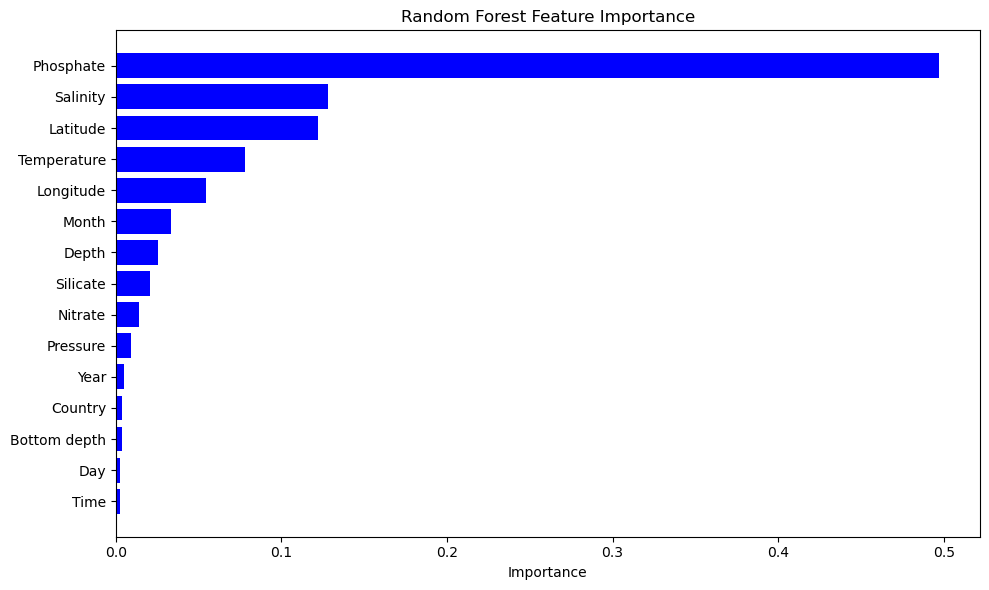

         Feature  Importance
11     Phosphate    0.496961
10      Salinity    0.128004
0       Latitude    0.121875
9    Temperature    0.078176
1      Longitude    0.054710
3          Month    0.033184
8          Depth    0.025777
12      Silicate    0.020828
13       Nitrate    0.014137
14      Pressure    0.009121
2           Year    0.004946
6        Country    0.003661
7   Bottom depth    0.003601
4            Day    0.002730
5           Time    0.002291


In [ ]:
# Feature Importance Test

# Get feature importance from your trained Random Forest
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='blue')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(feature_importance)

**Observation:**
The model relies heavily on Phosphate (49.6%) as the dominant predictor, followed by Salinity (12.8%) and Latitude (12.3%). Physical variables like depth and pressure show surprisingly low importance, likely due to redundancy with nutrient profiles. This single-feature dominance suggests potential model vulnerability when phosphate measurements are unreliable—a risk to be explored in failure analysis.

ABLATION TEST - Impact of Removing Each Feature (100 trees)
Baseline RMSE (100 trees, 15 features): 14.48
[1/6] Removing Phosphate... RMSE=14.34 (Δ -0.14, -1.0%) [14.3 min]
[2/6] Removing Salinity... RMSE=15.21 (Δ +0.73, +5.0%) [13.9 min]
[3/6] Removing Latitude... RMSE=14.34 (Δ -0.15, -1.0%) [14.5 min]
[4/6] Removing Temperature... RMSE=13.84 (Δ -0.65, -4.5%) [13.8 min]
[5/6] Removing Longitude... RMSE=14.83 (Δ +0.34, +2.4%) [14.3 min]
[6/6] Removing Month... RMSE=17.24 (Δ +2.76, +19.0%) [14.9 min]

SUMMARY - Sorted by Impact
    Feature      RMSE  Increase   % Worse  Time (min)
      Month 17.241655  2.757436 19.037523   14.923202
   Salinity 15.212683  0.728464  5.029365   13.855155
  Longitude 14.826253  0.342034  2.361424   14.267439
  Phosphate 14.342070 -0.142148 -0.981402   14.314131
   Latitude 14.336150 -0.148068 -1.022274   14.458011
Temperature 13.835506 -0.648713 -4.478756   13.806211

Total execution time: 85.6 minutes


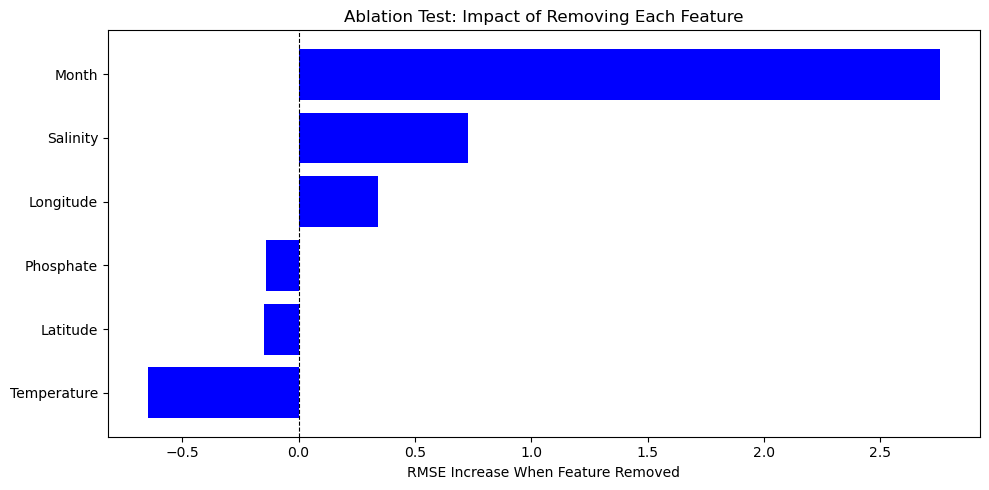

In [ ]:
# Ablation Tests

top_features = ['Phosphate', 'Salinity', 'Latitude', 'Temperature', 'Longitude', 'Month']

# Get baseline RMSE from best tuned model
baseline_pred = best_rf_model.predict(X_test)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

print("ABLATION TEST - Impact of Removing Each Feature (100 trees)")
print("="*70)
print(f"Baseline RMSE (100 trees, 15 features): {baseline_rmse:.2f}")

ablation_results = []
start_total = time.time()

for i, feature in enumerate(top_features, 1):
    print(f"[{i}/{len(top_features)}] Removing {feature}...", end=" ", flush=True)
    start = time.time()

    # Drop feature
    X_train_ablation = X_train.drop(feature, axis=1)
    X_test_ablation = X_test.drop(feature, axis=1)

    # Train model
    rf = RandomForestRegressor(**best_params)
    rf.fit(X_train_ablation, y_train)
    pred = rf.predict(X_test_ablation)

    # Calculate performance
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    rmse_increase = rmse - baseline_rmse
    percent_worse = (rmse_increase / baseline_rmse) * 100
    elapsed = time.time() - start

    ablation_results.append({
        'Feature': feature,
        'RMSE': rmse,
        'Increase': rmse_increase,
        '% Worse': percent_worse,
        'Time (min)': elapsed/60
    })

    print(f"RMSE={rmse:.2f} (Δ {rmse_increase:+.2f}, {percent_worse:+.1f}%) [{elapsed/60:.1f} min]")

total_time = time.time() - start_total

# Display results
print("\n" + "="*70)
print("SUMMARY - Sorted by Impact")
print("="*70)
ablation_df = pd.DataFrame(ablation_results).sort_values('Increase', ascending=False)
print(ablation_df.to_string(index=False))
print(f"\nTotal execution time: {total_time/60:.1f} minutes")

# Visualization

plt.figure(figsize=(10, 5))
plt.barh(ablation_df['Feature'], ablation_df['Increase'], color='blue')
plt.xlabel('RMSE Increase When Feature Removed')
plt.title('Ablation Test: Impact of Removing Each Feature')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Baseline RMSE (tuned model): 14.48

Testing n_estimators sensitivity:
  n_estimators= 10: RMSE=16.36
  n_estimators= 25: RMSE=15.84
  n_estimators= 50: RMSE=14.97
  n_estimators=100: RMSE=14.68
  n_estimators=200: RMSE=14.48

Testing max_depth sensitivity:
  max_depth=5    : RMSE=37.35
  max_depth=10   : RMSE=23.51
  max_depth=15   : RMSE=17.53
  max_depth=20   : RMSE=15.28
  max_depth=None : RMSE=14.68

Testing min_samples_split sensitivity:
  min_samples_split=  2: RMSE=14.68
  min_samples_split= 10: RMSE=15.20
  min_samples_split= 50: RMSE=16.72
  min_samples_split=100: RMSE=17.54

Testing min_samples_leaf sensitivity:
  min_samples_leaf=  1: RMSE=14.68
  min_samples_leaf=  2: RMSE=14.52
  min_samples_leaf=  4: RMSE=19.04
  min_samples_leaf=  8: RMSE=25.64


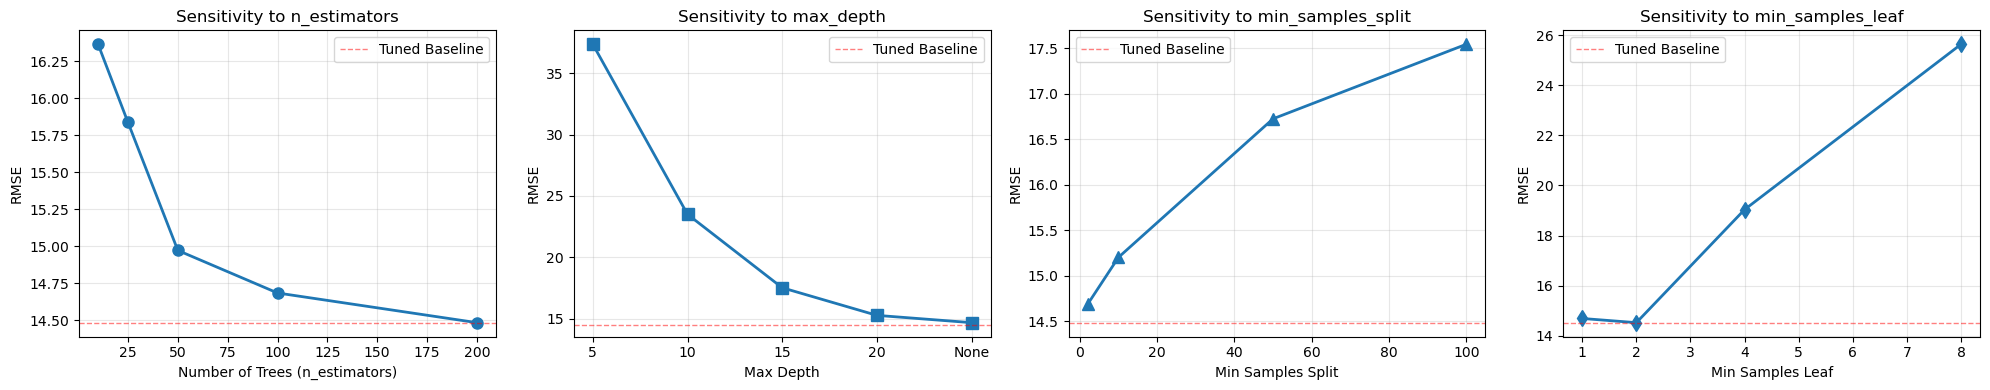

In [ ]:
# Hyperparameter Sensitivity Analysis
# Test how model performance changes with different hyperparameter settings to assess model stability

# Get baseline from best tuned model
baseline_rmse = np.sqrt(mean_squared_error(y_test, best_rf_model.predict(X_test)))
print(f"Baseline RMSE (tuned model): {baseline_rmse:.2f}\n")

# Test 1: Number of trees (n_estimators)
print("Testing n_estimators sensitivity:")
n_estimators_range = [10, 25, 50, 100, 200]
n_est_results = []
for n_est in n_estimators_range:
    rf = RandomForestRegressor(n_estimators=n_est, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    n_est_results.append(rmse)
    print(f"  n_estimators={n_est:3d}: RMSE={rmse:.2f}")

# Test 2: Max depth
print("\nTesting max_depth sensitivity:")
max_depth_range = [5, 10, 15, 20, None]
depth_results = []
depth_labels = []
for depth in max_depth_range:
    rf = RandomForestRegressor(n_estimators=100, max_depth=depth, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    depth_results.append(rmse)
    depth_labels.append(str(depth))
    print(f"  max_depth={str(depth):5s}: RMSE={rmse:.2f}")

# Test 3: Min samples split
print("\nTesting min_samples_split sensitivity:")
min_samples_range = [2, 10, 50, 100]
samples_results = []
for min_s in min_samples_range:
    rf = RandomForestRegressor(n_estimators=100, min_samples_split=min_s, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    samples_results.append(rmse)
    print(f"  min_samples_split={min_s:3d}: RMSE={rmse:.2f}")

# Test 4: Min samples leaf
print("\nTesting min_samples_leaf sensitivity:")
min_leaf_range = [1, 2, 4, 8]
leaf_results = []
for min_l in min_leaf_range:
    rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=min_l, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    leaf_results.append(rmse)
    print(f"  min_samples_leaf={min_l:3d}: RMSE={rmse:.2f}")

# Visualization
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# Plot 1: n_estimators
axes[0].plot(n_estimators_range, n_est_results, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Trees (n_estimators)')
axes[0].set_ylabel('RMSE')
axes[0].set_title('Sensitivity to n_estimators')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=baseline_rmse, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Tuned Baseline')
axes[0].legend()

# Plot 2: max_depth
axes[1].plot(range(len(depth_labels)), depth_results, marker='s', linewidth=2, markersize=8)
axes[1].set_xticks(range(len(depth_labels)))
axes[1].set_xticklabels(depth_labels)
axes[1].set_xlabel('Max Depth')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Sensitivity to max_depth')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=baseline_rmse, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Tuned Baseline')
axes[1].legend()

# Plot 3: min_samples_split
axes[2].plot(min_samples_range, samples_results, marker='^', linewidth=2, markersize=8)
axes[2].set_xlabel('Min Samples Split')
axes[2].set_ylabel('RMSE')
axes[2].set_title('Sensitivity to min_samples_split')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=baseline_rmse, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Tuned Baseline')
axes[2].legend()

# Plot 4: min_samples_leaf
axes[3].plot(min_leaf_range, leaf_results, marker='d', linewidth=2, markersize=8)
axes[3].set_xlabel('Min Samples Leaf')
axes[3].set_ylabel('RMSE')
axes[3].set_title('Sensitivity to min_samples_leaf')
axes[3].grid(True, alpha=0.3)
axes[3].axhline(y=baseline_rmse, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Tuned Baseline')
axes[3].legend()

plt.tight_layout()
plt.show()

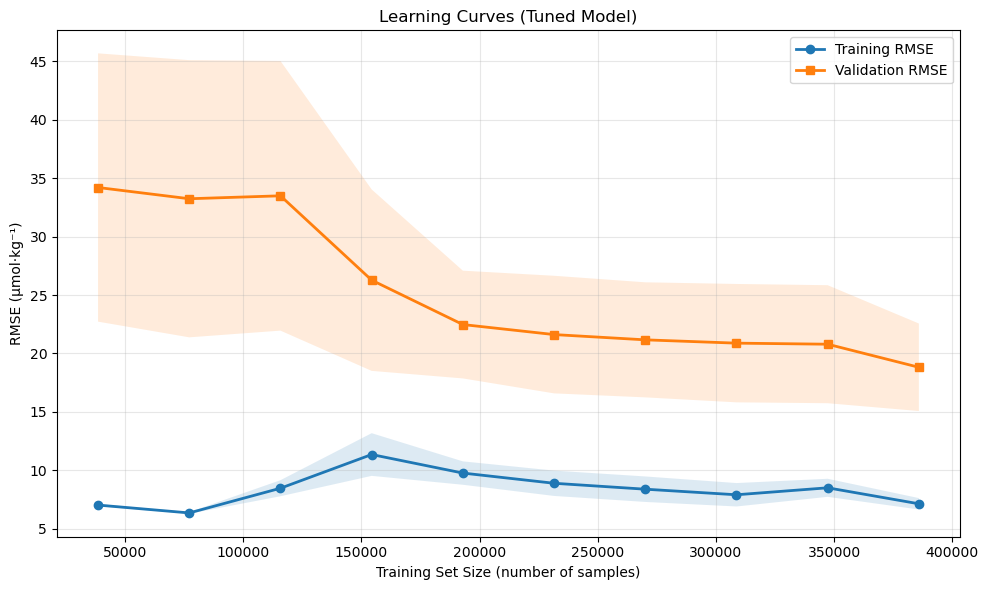

Training sizes tested: [ 38585  77171 115756 154342 192928 231513 270099 308684 347270 385856]
Final validation RMSE: 18.82 ± 3.75
Final training RMSE: 7.13 ± 0.49
Gap (val - train): 11.68


In [ ]:
# Learning Curves Analysis
# Shows whether or not adding more training data would improve model performance.


# Use SAME KFold as other analyses for consistency
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Generate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    RandomForestRegressor(**best_params, random_state=42, n_jobs=-1),
    X_train, y_train,
    cv=kf,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_squared_error'
)

# Convert to RMSE
train_rmse = np.sqrt(-train_scores.mean(axis=1))
train_rmse_std = np.sqrt(-train_scores).std(axis=1)
val_rmse = np.sqrt(-val_scores.mean(axis=1))
val_rmse_std = np.sqrt(-val_scores).std(axis=1)

# Plot with confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse, 'o-', label='Training RMSE', linewidth=2, markersize=6)
plt.fill_between(train_sizes, train_rmse - train_rmse_std, train_rmse + train_rmse_std, alpha=0.15)

plt.plot(train_sizes, val_rmse, 's-', label='Validation RMSE', linewidth=2, markersize=6)
plt.fill_between(train_sizes, val_rmse - val_rmse_std, val_rmse + val_rmse_std, alpha=0.15)

plt.xlabel('Training Set Size (number of samples)')
plt.ylabel('RMSE (μmol·kg⁻¹)')
plt.title('Learning Curves (Tuned Model)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Training sizes tested: {train_sizes.astype(int)}")
print(f"Final validation RMSE: {val_rmse[-1]:.2f} ± {val_rmse_std[-1]:.2f}")
print(f"Final training RMSE: {train_rmse[-1]:.2f} ± {train_rmse_std[-1]:.2f}")
print(f"Gap (val - train): {val_rmse[-1] - train_rmse[-1]:.2f}")

### Failure Tests

In [ ]:
# 10 Cases of Model's Worst Predictive Performance

# Get predictions and calculate errors
y_pred = best_rf_model.predict(X_test)
errors = pd.Series(np.abs(y_test - y_pred), index=y_test.index, name='Absolute_Error')

# Find top 10 worst predictions
worst_predictions = errors.nlargest(10)

print("=" * 80)
print("TOP 10 WORST PREDICTIONS")
print("=" * 80)

for rank, (idx, error) in enumerate(worst_predictions.items(), 1):
    actual = y_test.loc[idx]
    predicted = y_pred[X_test.index.get_loc(idx)]
    
    print(f"\n#{rank} - Index: {idx}")
    print(f"  Actual O₂:    {actual:.2f} μmol·kg⁻¹")
    print(f"  Predicted O₂: {predicted:.2f} μmol·kg⁻¹")
    print(f"  Error:        {error:.2f} μmol·kg⁻¹")
    print(f"  Features:")
    for feature, value in X_test.loc[idx].items():
        print(f"    {feature:15s}: {value}")

TOP 10 WORST PREDICTIONS

#1 - Index: 468606
  Actual O₂:    242.90 μmol·kg⁻¹
  Predicted O₂: 1487.22 μmol·kg⁻¹
  Error:        1244.32 μmol·kg⁻¹
  Features:
    Latitude       : 22.4997
    Longitude      : -27.5992
    Year           : 2013.0
    Month          : 9.0
    Day            : 8.0
    Time           : 13.23
    Country        : 24.0
    Bottom depth   : 5505.0
    Depth          : 5476.61
    Temperature    : 2.4722
    Salinity       : 34.8818
    Phosphate      : 1.52
    Silicate       : 47.1
    Nitrate        : 22.4
    Pressure       : 5582.8

#2 - Index: 469811
  Actual O₂:    314.80 μmol·kg⁻¹
  Predicted O₂: 1329.72 μmol·kg⁻¹
  Error:        1014.92 μmol·kg⁻¹
  Features:
    Latitude       : 68.9262
    Longitude      : -53.2695
    Year           : 2013.0
    Month          : 9.0
    Day            : 23.0
    Time           : 19.65
    Country        : 24.0
    Bottom depth   : 601.0
    Depth          : 2.77
    Temperature    : 4.2537
    Salinity       : 32.743

In [ ]:
# SHAP Analysis of 10 Cases of Model's Worst Predictive Performance

# Get prediction errors
errors = np.abs(y_test - y_pred)
top_10_indices = errors.nlargest(10).index

print("SHAP Analysis for Top 10 Failure Cases")
print("="*80)

# create explainer once
explainer = shap.TreeExplainer(best_rf_model)

# analyze each case individually
for rank, idx in enumerate(top_10_indices, 1):
    # get just this one row
    single_row = X_test.loc[[idx]]
    
    # SHAP for just this one prediction
    shap_vals = explainer.shap_values(single_row)[0]
    
    actual = y_test.loc[idx]
    pred = y_pred[X_test.index.get_loc(idx)]
    error = abs(actual - pred)
    
    print(f"\nrank {rank} - index {idx}:")
    print(f"  actual: {actual:.1f}, predicted: {pred:.1f}, error: {error:.1f}")
    
    shap_contributions = list(zip(X_test.columns, shap_vals))
    shap_contributions.sort(key=lambda x: abs(x[1]), reverse=True)
    
    for feat, val in shap_contributions:
        direction = "pushes prediction UP" if val > 0 else "pushes prediction DOWN"
        print(f"    {feat:12s}: {val:+8.1f} ({direction})")
    
    print("-"*80)

SHAP Analysis for Top 10 Failure Cases

rank 1 - index 468606:
  actual: 242.9, predicted: 1487.2, error: 1244.3
    Depth       :   +358.3 (pushes prediction UP)
    Temperature :   +310.2 (pushes prediction UP)
    Nitrate     :   +224.7 (pushes prediction UP)
    Phosphate   :   +165.0 (pushes prediction UP)
    Pressure    :   +109.8 (pushes prediction UP)
    Salinity    :    +83.3 (pushes prediction UP)
    Latitude    :    +32.5 (pushes prediction UP)
    Silicate    :    -16.9 (pushes prediction DOWN)
    Month       :     -6.6 (pushes prediction DOWN)
    Bottom depth:     +6.0 (pushes prediction UP)
    Longitude   :     +0.8 (pushes prediction UP)
    Year        :     +0.6 (pushes prediction UP)
    Country     :     -0.4 (pushes prediction DOWN)
    Day         :     +0.2 (pushes prediction UP)
    Time        :     +0.1 (pushes prediction UP)
--------------------------------------------------------------------------------

rank 2 - index 469811:
  actual: 314.8, predicted

In [ ]:
# Failure Analysis for 3 selected cases

# selected cases
failure_cases = {
    'Case 1': 468606,   # deep ocean
    'Case 2': 469811,   # geographic location
    'Case 3': 186984,   # data quality
}

In [ ]:
# Detailed SHAP Analysis and Plots for 3 Selected Cases

# Create explainer
explainer = shap.TreeExplainer(best_rf_model)

# Analyze each case
for case_name, idx in failure_cases.items():
    print(f"\n{'='*70}")
    print(f"SHAP ANALYSIS: {case_name} (Index {idx})")
    print(f"{'='*70}")
    
    # Get SHAP values
    shap_values = explainer.shap_values(X_test.loc[[idx]])
    
    # Top 8 features
    feature_contrib = pd.DataFrame({
        'Feature': X_test.columns,
        'SHAP Value': shap_values[0],
        'Feature Value': X_test.loc[idx].values
    }).sort_values('SHAP Value', key=abs, ascending=False)
    
    print("\nFeature Contributions:")
    # print(feature_contrib.to_string(index=False))
    from IPython.display import display
    display(feature_contrib)
    
    # Clean bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Sort for better visualization
    feature_contrib_sorted = feature_contrib.sort_values('SHAP Value')
    
    colors = ['blue' if x < 0 else 'red' for x in feature_contrib_sorted['SHAP Value']]
    
    bars = ax.barh(range(len(feature_contrib_sorted)), 
                   feature_contrib_sorted['SHAP Value'], 
                   color=colors, alpha=0.7, edgecolor='black', linewidth=1.2)
    
    ax.set_yticks(range(len(feature_contrib_sorted)))
    ax.set_yticklabels([f"{feat} = {val:.2f}" for feat, val in 
                        zip(feature_contrib_sorted['Feature'], 
                            feature_contrib_sorted['Feature Value'])],
                       fontsize=10)
    
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('SHAP Value (μmol·kg⁻¹)', fontsize=12, fontweight='bold')
    ax.set_title(f'{case_name} - Feature Contributions to Prediction', 
                 fontsize=13, fontweight='bold', pad=15)
    ax.grid(alpha=0.3, axis='x')
    
    # Add legend

    legend_elements = [Patch(facecolor='red', alpha=0.7, label='Increases prediction'),
                      Patch(facecolor='blue', alpha=0.7, label='Decreases prediction')]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

Generating Residual Plots


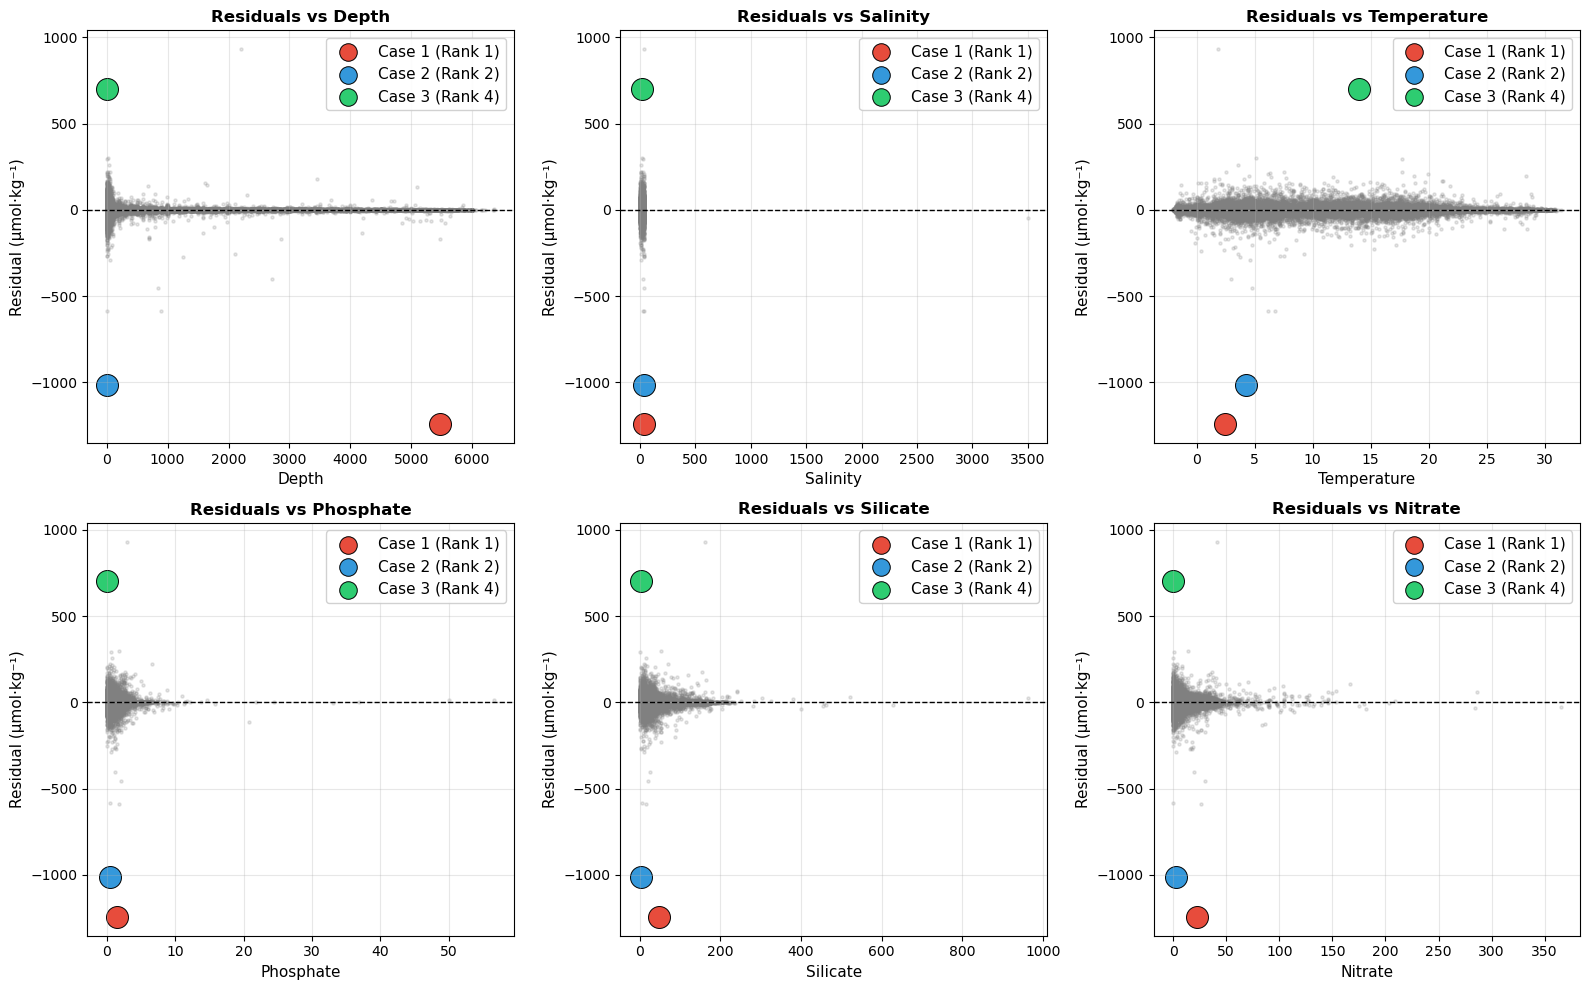

In [ ]:
# Residual Patterns - visual
print("Generating Residual Plots")

residuals = y_test - pd.Series(y_pred, index=X_test.index)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
features = ['Depth', 'Salinity', 'Temperature', 'Phosphate', 'Silicate', 'Nitrate']
colors = ['#e74c3c', '#3498db', '#2ecc71']  # red, blue, green
markers = ['o', 'o', 'o']  

for i, feature in enumerate(features):
    ax = axes[i // 3, i % 3]
    
    # All points
    ax.scatter(X_test[feature], residuals, alpha=0.2, s=5, color='gray')
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    
    # Highlight failure cases
    for j, (name, idx) in enumerate(failure_cases.items()):
        ax.scatter(X_test.loc[idx, feature], residuals.loc[idx],
                  s=250, marker=markers[j], color=colors[j], 
                  edgecolors='black', linewidth=0.7, label=name, zorder=1)
    
    ax.set_xlabel(feature, fontsize=11)
    ax.set_ylabel('Residual (μmol·kg⁻¹)', fontsize=11)
    ax.set_title(f'Residuals vs {feature}', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(fontsize=11, loc='upper right', framealpha=0.9, 
                 markerscale=0.8, handletextpad=1)

plt.tight_layout()
plt.show()


In [ ]:
# Distribution Check - is case in extreme region?
print("Distribution Check")

for case_name, idx in failure_cases.items():
    print(f"\n{case_name} (index: {idx})")
    print("-"*80)
    
    actual = y_test.loc[idx]
    pred = y_pred[X_test.index.get_loc(idx)]
    error = abs(actual - pred)
    
    # print(f"Oxygen: actual: {actual:.1f}, predicted: {pred:.1f}, error: {error:.1f} μmol·kg⁻¹")
    
    # check feature percentiles
    print(f"\nFeature Percentiles in Training Data:")
    for feature in ['Depth', 'Salinity', 'Temperature', 'Phosphate']:
        value = X_test.loc[idx, feature]
        pct = (X_train[feature] < value).mean() * 100
        
        status = ""
        if pct < 5 or pct > 95:
            status = " <- extreme"
        
        print(f"  {feature:12s}: {value:8.2f} ({pct:5.1f}%){status}")

Distribution Check

Case 1 (Rank 1) (index: 468606)
--------------------------------------------------------------------------------

Feature Percentiles in Training Data:
  Depth       :  5476.61 ( 99.7%) <- extreme
  Salinity    :    34.88 ( 84.9%)
  Temperature :     2.47 ( 24.8%)
  Phosphate   :     1.52 ( 59.4%)

Case 2 (Rank 2) (index: 469811)
--------------------------------------------------------------------------------

Feature Percentiles in Training Data:
  Depth       :     2.77 (  8.3%)
  Salinity    :    32.74 ( 29.8%)
  Temperature :     4.25 ( 38.8%)
  Phosphate   :     0.42 ( 25.3%)

Case 3 (Rank 4) (index: 186984)
--------------------------------------------------------------------------------

Feature Percentiles in Training Data:
  Depth       :     0.00 (  0.0%) <- extreme
  Salinity    :    17.18 ( 20.3%)
  Temperature :    14.00 ( 81.8%)
  Phosphate   :     0.03 (  2.9%) <- extreme


In [ ]:
# Nearest Neighbor Check - does model have similar training examples
print("Nearest Neighbor Analysis")

scaler_nn = StandardScaler()
X_train_scaled = scaler_nn.fit_transform(X_train)
X_test_scaled = scaler_nn.transform(X_test)

for case_name, idx in failure_cases.items():
    print(f"\n{case_name} (index: {idx})")
    print("-"*80)
    
    test_point = X_test_scaled[X_test.index.get_loc(idx)].reshape(1, -1)
    distances = cdist(test_point, X_train_scaled, metric='euclidean')[0]
    
    nearest_5 = np.argsort(distances)[:5]
    
    print(f"distance to nearest:  {distances[nearest_5[0]]:.3f}")
    print(f"median to all train:  {np.median(distances):.3f}")
    
    if distances[nearest_5[0]] > np.percentile(distances, 75):
        print("→ isolated from training data")
    
    # nearest neighbors' oxygen values
    nearest_o2 = y_train.iloc[nearest_5].values
    actual_o2 = y_test.loc[idx]
    
    print(f"\nnearest 5 oxygen values: {nearest_o2}")
    print(f"mean: {nearest_o2.mean():.1f}, actual: {actual_o2:.1f}")

Nearest Neighbor Analysis

Case 1 (Rank 1) (index: 468606)
--------------------------------------------------------------------------------
distance to nearest:  0.146
median to all train:  7.578

nearest 5 oxygen values: [241.8 242.7 242.1 243.8 242.6]
mean: 242.6, actual: 242.9

Case 2 (Rank 2) (index: 469811)
--------------------------------------------------------------------------------
distance to nearest:  0.365
median to all train:  4.565

nearest 5 oxygen values: [313.3 318.9 312.1 297.8 321.1]
mean: 312.6, actual: 314.8

Case 3 (Rank 4) (index: 186984)
--------------------------------------------------------------------------------
distance to nearest:  0.039
median to all train:  4.213

nearest 5 oxygen values: [9261.2 9349.1 9221.  9285.3  261. ]
mean: 7475.5, actual: 9573.5


In [ ]:
# Physical Constraint Check - is data valid
print("Physical Constraint Validation")

constraints = {
    'Oxygen': (0, 450),
    'Salinity': (0, 42),
    'Temperature': (-2, 35),
    'Pressure': (-5, 11000),
    'Phosphate': (0, 4),
    'Nitrate': (0, 50),
    'Silicate': (0, 200)
}

for case_name, idx in failure_cases.items():
    print(f"\n{case_name} (index: {idx})")
    print("-"*80)
    
    case_data = X_test.loc[idx].to_dict()
    case_data['Oxygen'] = y_test.loc[idx]
    
    violations = []
    for feature, (min_val, max_val) in constraints.items():
        if feature in case_data:
            value = case_data[feature]
            if value < min_val or value > max_val:
                violations.append(f"{feature}={value:.1f} (valid: {min_val}-{max_val})")
    
    if violations:
        print("constraint violations:")
        for v in violations:
            print(f"  {v}")
        print("→ data quality issue")
    else:
        print("no constraint violations")

Physical Constraint Validation

Case 1 (Rank 1) (index: 468606)
--------------------------------------------------------------------------------
no constraint violations

Case 2 (Rank 2) (index: 469811)
--------------------------------------------------------------------------------
no constraint violations

Case 3 (Rank 4) (index: 186984)
--------------------------------------------------------------------------------
constraint violations:
  Oxygen=9573.5 (valid: 0-450)
→ data quality issue


In [ ]:
# Oxygen Violations at Shallow Depths (where garcia & gordon (1992) applies)

print("Oxygen Violations at Shallow Depths")

# Surface/shallow water in equilibrium with atmosphere
shallow_data = df[df['Depth'] < 200]

print(f"\nShallow Records (<200m): {len(shallow_data):,}")
print(f"Percentage of Total Data: {len(shallow_data)/len(df)*100:.1f}%")

# Check Violations
oxygen_max_saturation = 450  # garcia & gordon (1992) - surface max at 0°c
oxygen_realistic_max = 400   # allowing for some supersaturation

shallow_violations = shallow_data[shallow_data['Oxygen'] > oxygen_max_saturation]
shallow_extreme = shallow_data[shallow_data['Oxygen'] > oxygen_realistic_max]

print(f"Shallow Oxygen > {oxygen_max_saturation} (impossible): {len(shallow_violations):,} ({len(shallow_violations)/len(shallow_data)*100:.2f}%)")
print(f"Shallow Oxygen > {oxygen_realistic_max} (unlikely): {len(shallow_extreme):,} ({len(shallow_extreme)/len(shallow_data)*100:.2f}%)")

# show some examples
if len(shallow_violations) > 0:
    print(f"\nTop 10 Worst Shallow Violations:")
    print("-"*80)
    worst_shallow = shallow_violations.nlargest(10, 'Oxygen')[['Oxygen', 'Depth', 'Salinity', 'Temperature', 'Country', 'Year']]
    print(worst_shallow.to_string())
    
    # check if case 3 is part of this problem
    if 186984 in shallow_violations.index:
        print(f"\nCase 3 (index 186984) is among Shallow Violations")
    
    # check clustering
    print(f"\nViolations by Country:")
    print(shallow_violations['Country'].value_counts().head(5))
    
    print(f"\nViolations by Year:")
    print(shallow_violations['Year'].value_counts().sort_index())

else:
    print("\nNo Shallow Depth Violations Found")

print("\n" + "="*80)

Oxygen Violations at Shallow Depths

Shallow Records (<200m): 346,311
Percentage of Total Data: 57.4%
Shallow Oxygen > 450 (impossible): 3,889 (1.12%)
Shallow Oxygen > 400 (unlikely): 17,268 (4.99%)

Top 10 Worst Shallow Violations:
--------------------------------------------------------------------------------
        Oxygen  Depth  Salinity  Temperature Country  Year
186984  9573.5   0.00   17.1800      14.0000      RU  2005
186983  9349.1   0.00   17.2000      14.0000      RU  2005
186978  9285.3   0.00   16.4900      14.0000      RU  2005
186985  9261.2   0.00   17.2300      14.0000      RU  2005
186988  9221.0   0.00   17.2000      14.0000      RU  2005
388948  4222.0   2.97   31.5836       4.8293      US  2010
452136   743.3   1.00   11.7760       5.6980      DK  2013
452189   732.0   1.00    8.0700       3.6530      DK  2013
452188   719.8   3.00   13.8160       3.2590      DK  2013
450229   714.5   1.00   27.4200      -0.4900      DK  2013

Case 3 (index 186984) is among Shall

In [ ]:
# Comparison to Similar Successful Cases

print("Comparison to Similar Cases")

for case_name, idx in failure_cases.items():
    print(f"\n{case_name} (index: {idx})")
    print("-"*80)
    
    error = abs(y_test.loc[idx] - y_pred[X_test.index.get_loc(idx)])
    
    # find similar cases
    if idx == 468606:  # Case 1: deep ocean
        mask = (X_test['Depth'] > 5000) & (X_test['Depth'] < 5500)
        desc = "depth 5000-5500m"
    elif idx == 469811:  # Case 2: Arctic
        mask = (X_test['Latitude'] > 60) & (X_test['Depth'] < 50)
        desc = "high latitude (>60°N), shallow (<50m)"
    else:  # Case 3: Black Sea (186984)
        mask = (X_test['Salinity'] > 15) & (X_test['Salinity'] < 20)
        desc = "salinity 15-20"
    
    similar = X_test[mask].index
    
    if len(similar) > 1:
        similar_errors = abs(y_test.loc[similar] - 
                           pd.Series(y_pred, index=X_test.index).loc[similar])
        
        print(f"similar cases ({desc}): {len(similar)}")
        print(f"  this error:     {error:.1f}")
        print(f"  similar mean:   {similar_errors.mean():.1f}")
        print(f"  similar median: {similar_errors.median():.1f}")
        print(f"  → {error/similar_errors.mean():.1f}x worse")
    else:
        print(f"no similar cases found")
        print("→ unique/rare case")

Comparison to Similar Cases

Case 1 (Rank 1) (index: 468606)
--------------------------------------------------------------------------------
similar cases (depth 5000-5500m): 834
  this error:     1244.3
  similar mean:   3.1
  similar median: 0.4
  → 406.1x worse

Case 2 (Rank 2) (index: 469811)
--------------------------------------------------------------------------------
similar cases (high latitude (>60°N), shallow (<50m)): 4242
  this error:     1014.9
  similar mean:   8.7
  similar median: 4.1
  → 117.3x worse

Case 3 (Rank 4) (index: 186984)
--------------------------------------------------------------------------------
similar cases (salinity 15-20): 2323
  this error:     703.4
  similar mean:   14.5
  similar median: 7.5
  → 48.5x worse


In [ ]:
# Geographical Sea Boundary Check
# Access IHO sea boundaries directly via marineregions.org API/services

print("Accessing IHO S-23 Sea Boundaries from marineregions.org")

# marineregions.org provides a REST API
# documentation: https://www.marineregions.org/gazetteer.php?p=webservices

def get_marine_region_name(lat, lon):
    """
    query marineregions.org API to find which IHO sea area a point belongs to
    """
    try:
        # marineregions gazetteer API
        url = f"https://www.marineregions.org/rest/getGazetteerRecordsByLatLong.json/{lat}/{lon}/"
        
        response = requests.get(url, timeout=10)
        
        if response.status_code == 200:
            data = response.json()
            
            # filter for IHO sea areas
            iho_areas = [r for r in data if 'IHO Sea Area' in r.get('placeType', '')]
            
            if iho_areas:
                return iho_areas[0].get('preferredGazetteerName', 'Unknown')
            else:
                return 'Open Ocean'
        else:
            return f'API Error: {response.status_code}'
    
    except Exception as e:
        return f'Error: {str(e)}'
    
# Check each failure case
for name, idx in failure_cases.items():
    lat = X_test.loc[idx, 'Latitude']
    lon = X_test.loc[idx, 'Longitude']
    
    print(f"\n{name} (index {idx}):")
    print(f"  coordinates: {lat:.4f}°N, {lon:.4f}°E")
    print(f"  querying API...")
    
    sea_name = get_marine_region_name(lat, lon)
    print(f"  IHO Sea Area: {sea_name}")

accessing IHO S-23 sea boundaries from marineregions.org

querying marineregions.org API for failure case locations...
--------------------------------------------------------------------------------

Case 1 (Rank 1) (index 468606):
  coordinates: 22.4997°N, -27.5992°E
  querying API...
  IHO Sea Area: North Atlantic Ocean

Case 2 (Rank 2) (index 469811):
  coordinates: 68.9262°N, -53.2695°E
  querying API...
  IHO Sea Area: Arctic Ocean

Case 3 (Rank 4) (index 186984):
  coordinates: 44.6667°N, 37.8333°E
  querying API...
  IHO Sea Area: Black Sea

API source: https://www.marineregions.org/
based on IHO S-23 'Limits of Oceans and Seas'


In [ ]:
# geographic coverage map with failure cases marked
import plotly.express as px
import plotly.graph_objects as go
# get unique coordinates
unique_df = df[['Latitude', 'Longitude']].drop_duplicates()
total_points = len(df)
unique_locations = len(unique_df)

print(f"Total data points: {total_points:,}")
print(f"Unique locations: {unique_locations:,}")
print(f"Duplicate locations: {total_points - unique_locations:,}")
print(f"Percentage unique: {(unique_locations/total_points)*100:.2f}%")

# scatter plot unique coordinates
fig = px.scatter_geo(unique_df,
                     lat='Latitude',
                     lon='Longitude',
                     title='WOD Data Coverage Map with Failure Cases',
                     projection='natural earth',
                     opacity=0.5)

fig.update_traces(marker=dict(size=3, color='blue'))

colors = ['red', 'orange', 'purple']

for i, (name, idx) in enumerate(failure_cases.items()):
    lat = X_test.loc[idx, 'Latitude']
    lon = X_test.loc[idx, 'Longitude']
    
    fig.add_trace(go.Scattergeo(
        lon=[lon],
        lat=[lat],
        mode='markers',
        marker=dict(
            size=20,
            color=colors[i],
            symbol='x',
            line=dict(width=3, color='black')
        ),
        name=name
    ))

fig.update_geos(
    showland=True,
    landcolor='lightgray',
    showocean=True,
    oceancolor='lightblue'
)

fig.show()

print("\nfailure case locations:")
for name, idx in failure_cases.items():
    lat = X_test.loc[idx, 'Latitude']
    lon = X_test.loc[idx, 'Longitude']
    print(f"{name}: {lat:.2f}°N, {lon:.2f}°E")

Total data points: 602,900
Unique locations: 23,472
Duplicate locations: 579,428
Percentage unique: 3.89%



failure case locations:
Case 1 (Rank 1): 22.50°N, -27.60°E
Case 2 (Rank 2): 68.93°N, -53.27°E
Case 3 (Rank 4): 44.67°N, 37.83°E
